In [55]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis, HLSConfig
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex
from qiskit import Aer, transpile
from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit.primitives import Estimator, Sampler

In [56]:
def heisenberg_model(qubits):

    pauli_strings = []
    for i in range(qubits - 1):
        pauli_string = ['I'] * qubits
        pauli_string[i] = 'X'
        pauli_string[i + 1] = 'X'
        pauli_strings.append(''.join(pauli_string))
        
        pauli_string = ['I'] * qubits
        pauli_string[i] = 'Y'
        pauli_string[i + 1] = 'Y'
        pauli_strings.append(''.join(pauli_string))
        
        pauli_string = ['I'] * qubits
        pauli_string[i] = 'Z'
        pauli_string[i + 1] = 'Z'
        pauli_strings.append(''.join(pauli_string))
    
    return pauli_strings

# Test cases
print(heisenberg_model(qubits=2))
print(heisenberg_model(qubits=3))
print(heisenberg_model(qubits=4))


['XX', 'YY', 'ZZ']
['XXI', 'YYI', 'ZZI', 'IXX', 'IYY', 'IZZ']
['XXII', 'YYII', 'ZZII', 'IXXI', 'IYYI', 'IZZI', 'IIXX', 'IIYY', 'IIZZ']


In [57]:
def lin_coupling_map(n):

    coupling_map = []
    for i in range(n - 1):
        coupling_map.append([i, i + 1])
        coupling_map.append([i + 1, i])  # Adding symmetric coupling
        
    return coupling_map

# Test case
print(lin_coupling_map(n=3))

[[0, 1], [1, 0], [1, 2], [2, 1]]


In [59]:
test_time_evolve = 3
cxcounts_cartan_array = []
test_qubits_array = [2, 3, 4]

for i in test_qubits_array:

    cxcounts_cartan_array_i = []

    for j in [-1,0,1,2,3,4,5,6,7,8,9]:

        # make qc_before
        ham_terms = heisenberg_model(qubits=i)
        test_heisenberg_ham = SparsePauliOp(data=ham_terms, coeffs=np.ones(len(ham_terms), dtype=int))
        test_paulievolutiongate = PauliEvolutionGate(operator=test_heisenberg_ham, 
                                                    time=test_time_evolve,
                                                    synthesis=MatrixExponential())
        qc_before = QuantumCircuit(i)
        qc_before.append(test_paulievolutiongate, range(i))

        # run cartan pass
        hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":j, "involution":"evenOdd"})])
        pm_hls = PassManager()
        pm_hls.append(HighLevelSynthesis(hls_config=hls_config))
        qc_hls = pm_hls.run(qc_before) 

        # run other passes
        pm_other = generate_preset_pass_manager(optimization_level=2, 
                                                layout_method="trivial",
                                                coupling_map=CouplingMap(lin_coupling_map(n=i)), 
                                                routing_method="sabre",
                                                translation_method="unroller",
                                                basis_gates="['u1', 'u2', 'u3', 'cx']",
                                                seed_transpiler=1)
        qc_after = pm_other.run(qc_hls)
        cx_count = qc_after.count_ops()['cx']
        cxcounts_cartan_array_i.append(cx_count)

    cxcounts_cartan_array.append(cxcounts_cartan_array_i)

Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
--- 0.08671259880065918 seconds ---
Optimization Error:
2.6437608884482626e-12
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.586419
         Iterations: 13
         Function evaluations: 22
         Gradient evaluations: 22
--- 0.06714487075805664 seconds ---
Optimization Error:
3.606967140699748e-12
Running Cartan Synthesis Plugin...
Optimiz

In [63]:
cxcounts_benchmark_array = []

for i in test_qubits_array:

    cxcounts_benchmark_array_i = []

    for j in [0,1,2,3,4,5,6,7,8,9,10]:

        # make qc_before
        ham_terms = heisenberg_model(qubits=i)
        test_heisenberg_ham = SparsePauliOp(data=ham_terms, coeffs=np.ones(len(ham_terms), dtype=int))
        test_paulievolutiongate = PauliEvolutionGate(operator=test_heisenberg_ham, 
                                                    time=test_time_evolve,
                                                    synthesis=MatrixExponential())
        qc_before = QuantumCircuit(i)
        qc_before.append(test_paulievolutiongate, range(i))

        # run passes passes
        pm_other = generate_preset_pass_manager(optimization_level=2, 
                                                layout_method="trivial",
                                                coupling_map=CouplingMap(lin_coupling_map(n=i)), 
                                                routing_method="sabre",
                                                translation_method="unroller",
                                                basis_gates="['u1', 'u2', 'u3', 'cx']",
                                                seed_transpiler=j)
        qc_after = pm_other.run(qc_before)
        cx_count = qc_after.count_ops()['cx']
        cxcounts_benchmark_array_i.append(cx_count)
    
    cxcounts_benchmark_array.append(cxcounts_benchmark_array_i)

In [64]:
cxcounts_cartan_array

[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 [50, 58, 60, 56, 50, 56, 60, 54, 54, 50, 54],
 [300, 387, 377, 365, 322, 373, 381, 371, 354, 349, 346]]

In [65]:
cxcounts_benchmark_array

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [34, 34, 32, 36, 34, 34, 36, 32, 36, 36, 32],
 [253, 253, 251, 253, 253, 253, 251, 253, 253, 251, 253]]

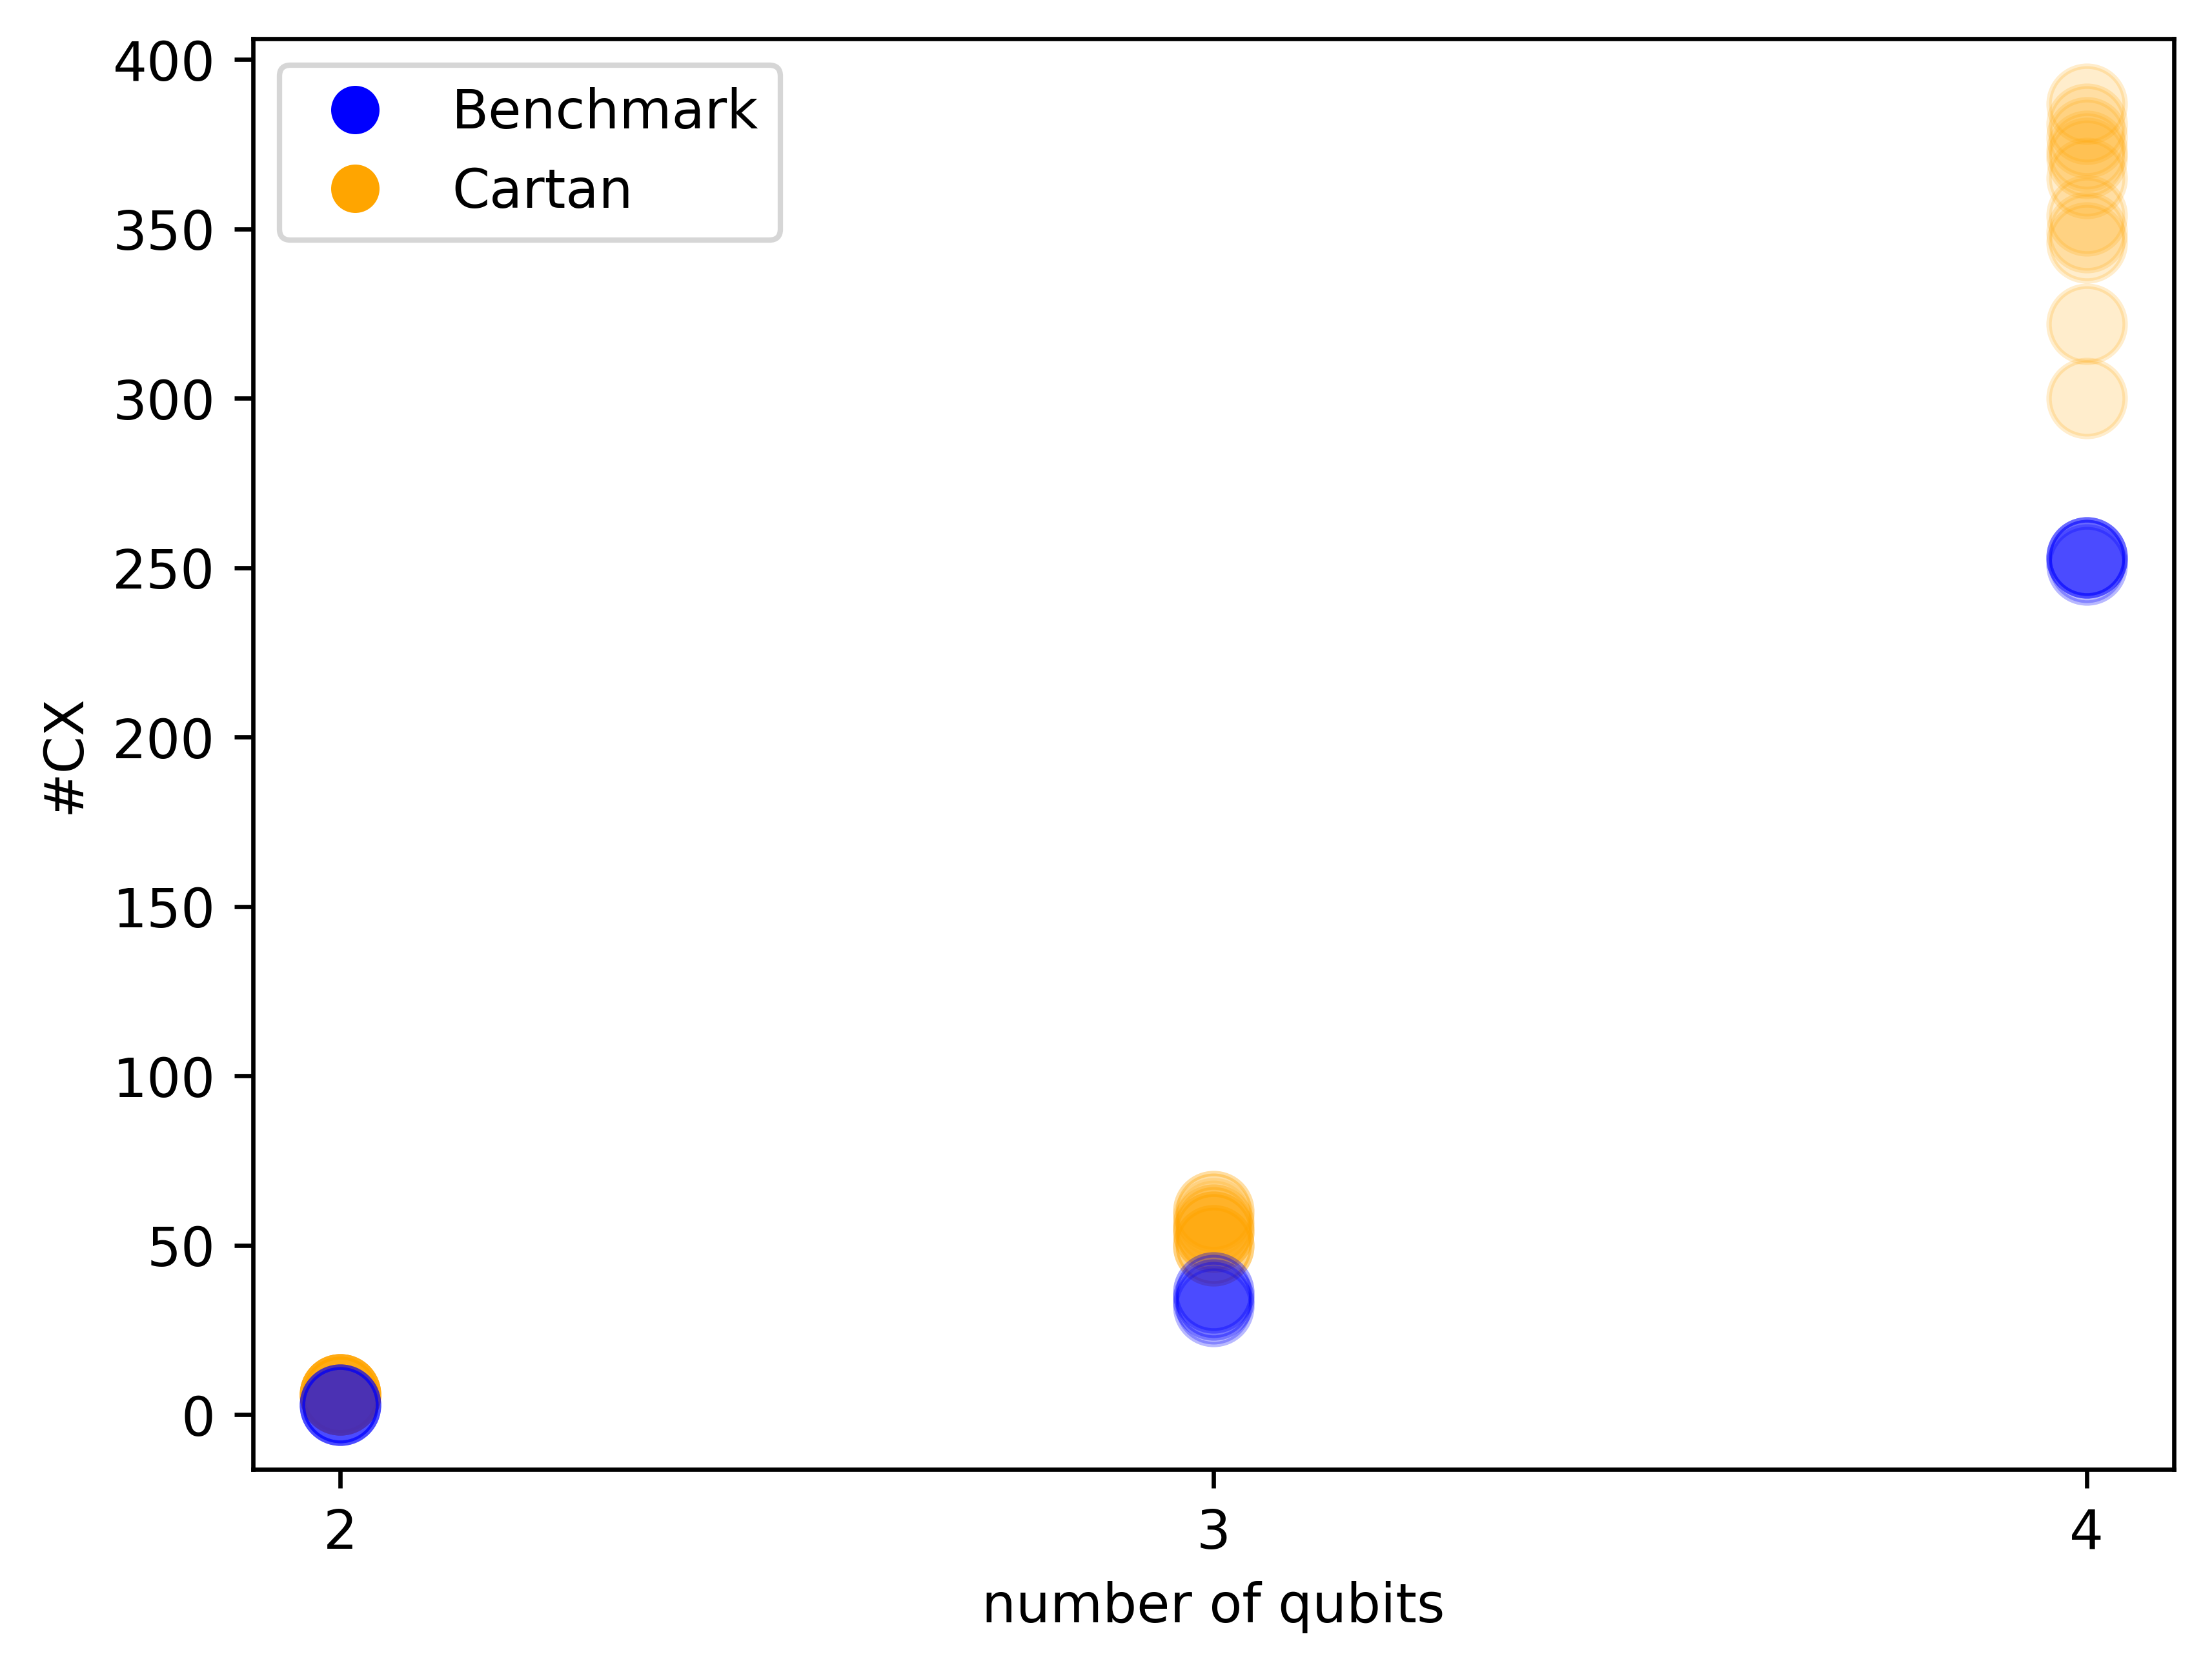

In [93]:
plt.figure(dpi=600)

for i in range(len(test_qubits_array)):

    cxcounts_cartan_array_i = cxcounts_cartan_array[i]

    for j in range(len(cxcounts_cartan_array_i)):

        plt.scatter(test_qubits_array[i], cxcounts_cartan_array_i[j], label="cartan", c="orange", s=200, alpha=0.2)


for i in range(len(test_qubits_array)):

    cxcounts_benchmark_array_i = cxcounts_benchmark_array[i]

    for j in range(len(cxcounts_cartan_array_i)):

        plt.scatter(test_qubits_array[i], cxcounts_benchmark_array_i[j], label="benchmark", c="blue", s=200, alpha=0.1)


# plt.yscale('log')
plt.xlabel("number of qubits")
plt.xticks(ticks=test_qubits_array)
plt.ylabel(r"#CX")
legend_labels = ['Benchmark', 'Cartan']
legend_markers = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10)]
plt.legend(legend_markers, legend_labels)
plt.savefig("test2")